
# Price–Demand EDA, Elasticity & Price Optimisation (Updated)

**Data:** `price_data.csv` (columns: `Price`, `Quantity`)  
**Generated:** 2025-10-16 19:47

This notebook expands the earlier analysis with:
- Focused **EDA** (shape, outliers, repeated prices).
- **Diagnostics** (residual checks, heteroskedasticity, influence).
- **Robust** fitting (HC3, WLS, Huber RLM).
- **Alternative demand forms** (log–log, quadratic).
- **Cross‑validated** polynomial–ridge baseline.
- **Elasticity** calculations and **price optimisation** for revenue/profit.


## 1) Setup

In [1]:
# If needed:
# !pip -q install pandas numpy matplotlib statsmodels patsy scikit-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.stats.diagnostic import het_breuschpagan

from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.metrics import make_scorer, r2_score

plt.rcParams['figure.figsize'] = (7, 4)
plt.rcParams['axes.grid'] = True
print("Libraries imported.")

Libraries imported.


## 2) Load data

In [2]:
from pathlib import Path

CANDIDATES = [
    Path("price_data.csv"),
    Path("./data/price_data.csv"),
    Path("../data/price_data.csv"),
    Path("/mnt/data/price_data.csv"),
]
DATA_PATH = next((p for p in CANDIDATES if p.exists()), CANDIDATES[0])
print("Using:", DATA_PATH)

df = pd.read_csv(DATA_PATH)
assert {"Price","Quantity"}.issubset(df.columns), "Expected columns: Price, Quantity"
df.head()

Using: price_data.csv


,Price,Quantity
0,192,80
1,145,960
2,240,200
3,240,150
4,375,740


## 3) Quick EDA

In [3]:
df.describe(include='all')

,Price,Quantity
count,1000.000000,1000.000000
mean,192.404000,1611.900000
std,84.275947,2534.252992
min,15.000000,60.000000
25%,145.000000,300.000000
50%,187.000000,700.000000
75%,216.000000,1907.500000
max,1008.000000,23150.000000


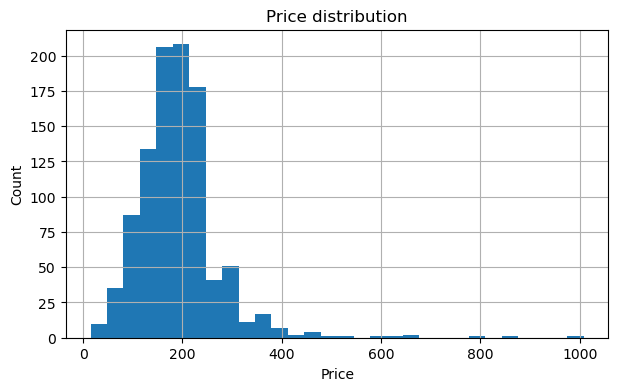

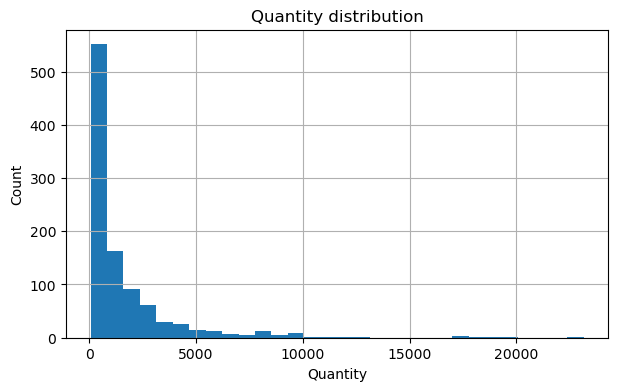

In [4]:
plt.figure()
plt.hist(df["Price"], bins=30)
plt.title("Price distribution"); plt.xlabel("Price"); plt.ylabel("Count"); plt.show()

plt.figure()
plt.hist(df["Quantity"], bins=30)
plt.title("Quantity distribution"); plt.xlabel("Quantity"); plt.ylabel("Count"); plt.show()

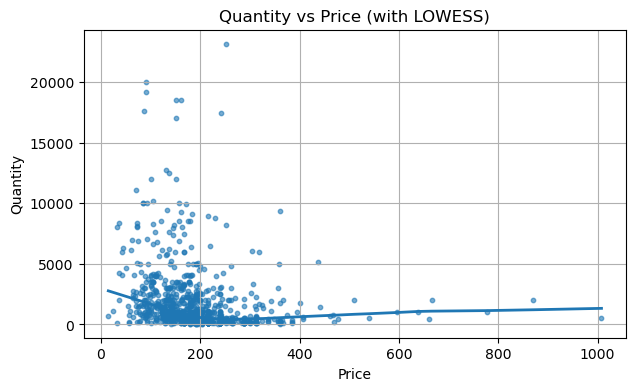

In [5]:
xy = df[["Price","Quantity"]].sort_values("Price")
trend = lowess(xy["Quantity"], xy["Price"], frac=0.3, return_sorted=True)

plt.figure()
plt.scatter(xy["Price"], xy["Quantity"], s=10, alpha=0.6)
plt.plot(trend[:,0], trend[:,1], linewidth=2)
plt.title("Quantity vs Price (with LOWESS)"); plt.xlabel("Price"); plt.ylabel("Quantity"); plt.show()

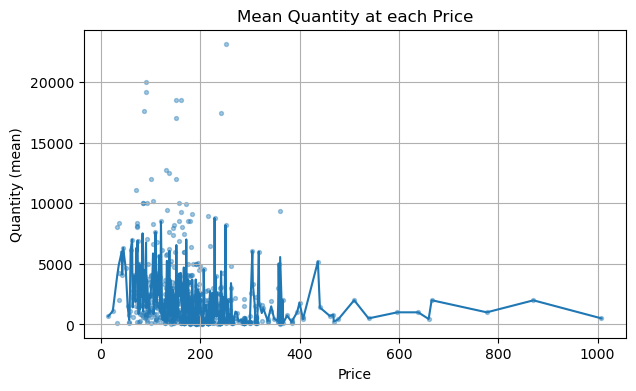

,Price,QuantityMean
0,15,680.0
1,24,1100.0
2,33,4050.0
3,36,4890.0
4,42,6000.0


In [6]:
agg = df.groupby("Price", as_index=False)["Quantity"].mean().rename(columns={"Quantity":"QuantityMean"})
plt.figure()
plt.scatter(df["Price"], df["Quantity"], s=8, alpha=0.4)
plt.plot(agg["Price"], agg["QuantityMean"])
plt.title("Mean Quantity at each Price"); plt.xlabel("Price"); plt.ylabel("Quantity (mean)"); plt.show()

agg.head()

## 4) Simple linear demand: `Quantity ~ Price`

In [7]:
X = sm.add_constant(df["Price"])
lin_mod = sm.OLS(df["Quantity"], X).fit()
print(lin_mod.summary())

# Robust SE (HC3)
lin_mod_robust = sm.OLS(df["Quantity"], X).fit(cov_type="HC3")
print("\n--- Robust (HC3) ---")
print(lin_mod_robust.summary())

a = lin_mod.params["const"]; b = lin_mod.params["Price"]
Pbar = df["Price"].mean(); Qbar = df["Quantity"].mean()
elasticity_linear_at_mean = b * (Pbar / Qbar)
print(f"\nElasticity at (Pbar,Qbar) ≈ {elasticity_linear_at_mean:.3f}")

                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     51.14
Date:                Thu, 16 Oct 2025   Prob (F-statistic):           1.66e-12
Time:                        21:53:43   Log-Likelihood:                -9231.1
No. Observations:                1000   AIC:                         1.847e+04
Df Residuals:                     998   BIC:                         1.848e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2889.2504    194.994     14.817      0.0

### Diagnostics

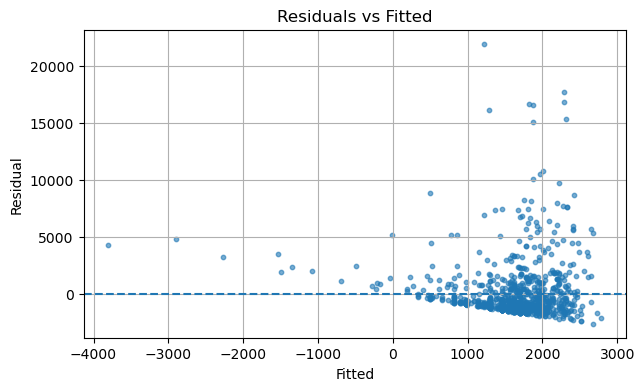

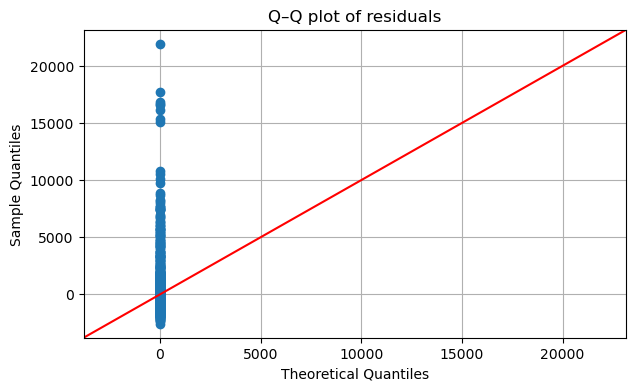

Breusch–Pagan heteroskedasticity test p-value: 0.06733


In [8]:
res = lin_mod.resid
fitted = lin_mod.fittedvalues

plt.figure()
plt.scatter(fitted, res, s=10, alpha=0.6)
plt.axhline(0, linestyle="--")
plt.title("Residuals vs Fitted"); plt.xlabel("Fitted"); plt.ylabel("Residual"); plt.show()

sm.qqplot(res, line="45"); plt.title("Q–Q plot of residuals"); plt.show()

bp_stat, bp_p, _, _ = het_breuschpagan(res, X)
print(f"Breusch–Pagan heteroskedasticity test p-value: {bp_p:.4g}")

In [9]:
infl = lin_mod.get_influence()
c, p = infl.cooks_distance
top = np.argsort(c)[-10:]
df.iloc[top]

,Price,Quantity
61,242,17410
384,361,9370
426,666,2000
790,777,1000
360,86,17630
58,90,19160
295,252,23150
639,91,20000
309,871,1990
877,1008,500


## 5) Alternative demand specifications

In [10]:
# (a) Log–log model
df_pos = df[(df["Price"]>0) & (df["Quantity"]>0)].copy()
log_mod = sm.OLS(np.log(df_pos["Quantity"]), sm.add_constant(np.log(df_pos["Price"]))).fit()
print(log_mod.summary())
elasticity_loglog = log_mod.params["Price"]
print(f"Estimated elasticity (log–log): {elasticity_loglog:.3f}")

                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     152.6
Date:                Thu, 16 Oct 2025   Prob (F-statistic):           1.01e-32
Time:                        21:53:44   Log-Likelihood:                -1562.7
No. Observations:                1000   AIC:                             3129.
Df Residuals:                     998   BIC:                             3139.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.1370      0.449     27.027      0.0

In [11]:
# (b) Quadratic model
quad_mod = smf.ols("Quantity ~ Price + I(Price**2)", data=df).fit()
print(quad_mod.summary())

b1 = quad_mod.params["Price"]
b2 = quad_mod.params["I(Price ** 2)"]
def elasticity_quadratic(P):
    Qhat = quad_mod.predict(pd.DataFrame({"Price":[P]})).iloc[0]
    dQdP = b1 + 2*b2*P
    return dQdP * (P / Qhat)

print("Quadratic elasticity at mean price:", elasticity_quadratic(Pbar))

                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     44.56
Date:                Thu, 16 Oct 2025   Prob (F-statistic):           2.92e-19
Time:                        21:53:44   Log-Likelihood:                -9213.3
No. Observations:                1000   AIC:                         1.843e+04
Df Residuals:                     997   BIC:                         1.845e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      4273.1862    299.446     14.270

In [12]:
# (c) WLS (weights ~ 1/Price^2)
w = 1.0 / (df["Price"]**2)
wls_mod = sm.WLS(df["Quantity"], sm.add_constant(df["Price"]), weights=w).fit()
print(wls_mod.summary())

# (d) Robust regression (Huber)
rlm = sm.RLM(df["Quantity"], sm.add_constant(df["Price"]), M=sm.robust.norms.HuberT())
rlm_fit = rlm.fit()
print(rlm_fit.summary())

                            WLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.043
Model:                            WLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     44.92
Date:                Thu, 16 Oct 2025   Prob (F-statistic):           3.42e-11
Time:                        21:53:44   Log-Likelihood:                -9662.9
No. Observations:                1000   AIC:                         1.933e+04
Df Residuals:                     998   BIC:                         1.934e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3363.2597    175.962     19.114      0.0

## 6) Cross‑validated baseline (Polynomial + Ridge)

In [13]:
X_skl = df[["Price"]].values
y_skl = df["Quantity"].values

pipe = Pipeline([
    ("scale", StandardScaler()),
    ("poly", PolynomialFeatures(degree=3, include_bias=False)),
    ("ridge", RidgeCV(alphas=np.logspace(-3,3,25), cv=5))
])

cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipe, X_skl, y_skl, cv=cv, scoring=make_scorer(r2_score))
print("5-fold CV R^2 (poly degree 3 ridge):", scores.mean())

pipe.fit(X_skl, y_skl)
lin_skl = LinearRegression()
scores_lin = cross_val_score(lin_skl, X_skl, y_skl, cv=cv, scoring=make_scorer(r2_score))
print("5-fold CV R^2 (plain linear):", scores_lin.mean())

5-fold CV R^2 (poly degree 3 ridge): 0.10385801394284226
5-fold CV R^2 (plain linear): 0.0512856733567862


## 7) Price optimisation

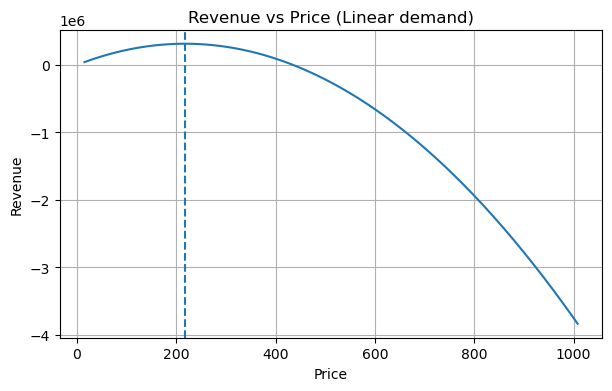

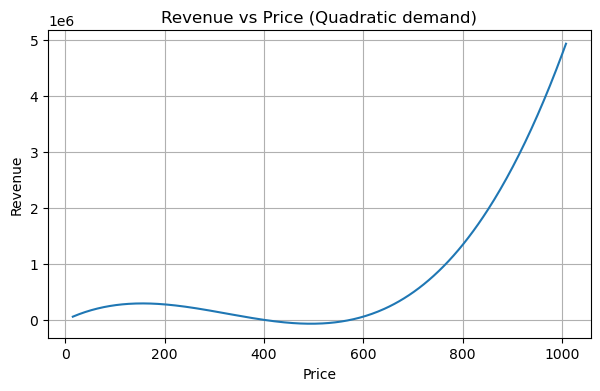

Revenue-maximising price (linear): 217.60


In [14]:
def demand_linear(p, a, b):
    return a + b*p

def demand_quadratic(p, b0, b1, b2):
    return b0 + b1*p + b2*(p**2)

def revenue(p, q):
    return p*q

def profit(p, q, c):
    return (p - c)*q

a, b = lin_mod.params["const"], lin_mod.params["Price"]
b0 = quad_mod.params["Intercept"]
b1 = quad_mod.params["Price"]
b2 = quad_mod.params["I(Price ** 2)"]

pmin, pmax = df["Price"].min(), df["Price"].max()
grid = np.linspace(pmin, pmax, 400)

P_star_rev_linear = (-a)/(2*b) if b < 0 else np.nan

rev_lin = revenue(grid, demand_linear(grid, a, b))
rev_quad = revenue(grid, demand_quadratic(grid, b0, b1, b2))

plt.figure()
plt.plot(grid, rev_lin)
if not np.isnan(P_star_rev_linear):
    plt.axvline(P_star_rev_linear, linestyle="--")
plt.title("Revenue vs Price (Linear demand)"); plt.xlabel("Price"); plt.ylabel("Revenue"); plt.show()

plt.figure()
plt.plot(grid, rev_quad)
plt.title("Revenue vs Price (Quadratic demand)"); plt.xlabel("Price"); plt.ylabel("Revenue"); plt.show()

print(f"Revenue-maximising price (linear): {P_star_rev_linear:.2f}")

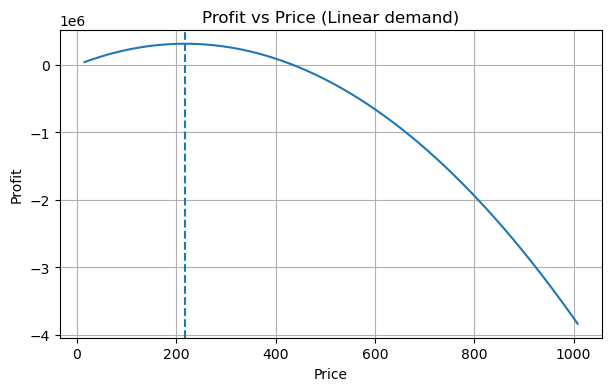

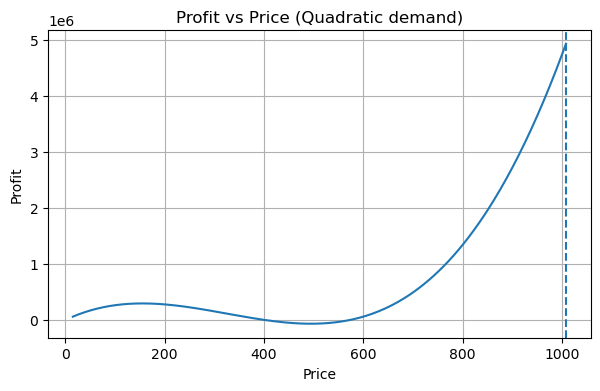

Profit-max (linear, c=0.0): 216.59
Profit-max (quadratic, c=0.0): 1008.00


In [15]:
c = 0.0  # <-- set your marginal cost here

prof_lin = profit(grid, demand_linear(grid, a, b), c)
prof_quad = profit(grid, demand_quadratic(grid, b0, b1, b2), c)

P_star_profit_lin = grid[np.argmax(prof_lin)]
P_star_profit_quad = grid[np.argmax(prof_quad)]

plt.figure()
plt.plot(grid, prof_lin)
plt.axvline(P_star_profit_lin, linestyle="--")
plt.title("Profit vs Price (Linear demand)"); plt.xlabel("Price"); plt.ylabel("Profit"); plt.show()

plt.figure()
plt.plot(grid, prof_quad)
plt.axvline(P_star_profit_quad, linestyle="--")
plt.title("Profit vs Price (Quadratic demand)"); plt.xlabel("Price"); plt.ylabel("Profit"); plt.show()

print(f"Profit-max (linear, c={c}): {P_star_profit_lin:.2f}")
print(f"Profit-max (quadratic, c={c}): {P_star_profit_quad:.2f}")


## 8) Summary & next steps
- Linear demand confirms a negative price effect; prefer **HC3/WLS** for inference.
- **Log–log** gives direct elasticity; **quadratic** captures curvature; **RLM** mitigates outliers.
- Compare models using **5‑fold CV**; add omitted drivers if available (promotions, seasonality, competition).
- Optimise **profit** (not just revenue) by setting marginal cost `c`.
